In [1]:
import sys
sys.path.append('../src/utils')  # Adjust this path based on your directory structure

# Import necessary libraries
import numpy as np
from po_fun import PO_util


In [2]:
import numpy as np
import networkx as nx
import random
import itertools
import matplotlib.pyplot as plt

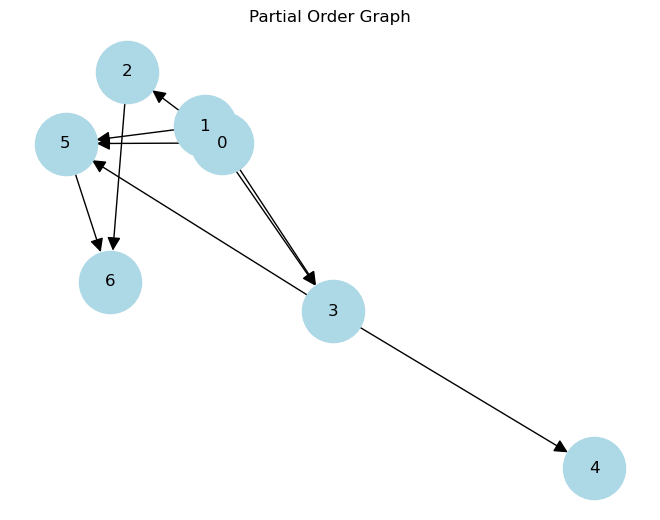

[[0 0 1 1 0 1 0]
 [0 0 0 1 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]


In [3]:
n = 7
random_PO = PO_util.generate_random_PO(n)
h = nx.to_numpy_array(random_PO, dtype=int)
PO_util.visualize_partial_order(h)
print(h)

In [4]:
#Step2: Create the Subsets 
N=20 # 20 observations 

def generate_subsets(N, n):
    """
    Generate N subsets O1, O2, ..., ON where:
    - N is the number of subsets.
    - n is the size of the universal set {1, 2, ..., n}.
    
    Each subset Oi is created by:
    - Determining the subset size ni by uniformly sampling from [2, n].
    - Randomly selecting ni distinct elements from the set {1, 2, ..., n}.
    """
    subsets = []
    universal_set = list(range(1, n + 1))  # Create the universal set {1, 2, ..., n}
    
    for _ in range(N):
        # Randomly sample the subset size ni from [2, n]
        ni = random.randint(2, n)
        # Randomly select ni distinct elements from the universal set
        subset = random.sample(universal_set, ni)
        subsets.append(subset)
    
    return subsets

def restrict_partial_order(h, subset):
    subset_indices = [i - 1 for i in subset]  # Convert 1-based indices to 0-based
    restricted_matrix = h[np.ix_(subset_indices, subset_indices)]
    return restricted_matrix, subset_indices

def compute_linear_extensions(restricted_matrix):

    G = nx.DiGraph(restricted_matrix)
    if not nx.is_directed_acyclic_graph(G):
        raise ValueError("The graph is not a directed acyclic graph (DAG).")
    # Compute all topological sorts
    linear_extensions = list(nx.all_topological_sorts(G))
    return linear_extensions

def sample_total_order(h, subset):
    restricted_matrix, subset_indices = restrict_partial_order(h, subset)
    linear_extensions = compute_linear_extensions(restricted_matrix)
    sampled_extension = random.choice(linear_extensions)
    # Map back to original element indices
    sampled_order = [subset[i] for i in sampled_extension]
    return sampled_order

In [5]:
subsets = generate_subsets(N, n)

total_orders = []
for subset in subsets:
    yi = sample_total_order(h, subset)
    total_orders.append(yi)

# Display Results
for i, (Oi, yi) in enumerate(zip(subsets, total_orders), 1):
    print(f"Subset O{i}: {Oi}")
    print(f"Sampled Total Order y{i}: {yi}\n")

Subset O1: [1, 3, 4, 6, 7]
Sampled Total Order y1: [1, 4, 6, 3, 7]

Subset O2: [1, 6, 3, 5]
Sampled Total Order y2: [1, 3, 6, 5]

Subset O3: [2, 1, 4, 6, 3]
Sampled Total Order y3: [1, 2, 4, 6, 3]

Subset O4: [3, 2, 6, 1, 7, 5, 4]
Sampled Total Order y4: [2, 1, 4, 3, 6, 5, 7]

Subset O5: [6, 4, 1, 5, 3, 2, 7]
Sampled Total Order y5: [2, 1, 4, 3, 5, 6, 7]

Subset O6: [6, 3, 7, 4, 2, 1]
Sampled Total Order y6: [1, 2, 3, 4, 6, 7]

Subset O7: [4, 6, 7, 3, 5]
Sampled Total Order y7: [4, 6, 3, 5, 7]

Subset O8: [7, 2, 6, 4, 5]
Sampled Total Order y8: [2, 4, 6, 7, 5]

Subset O9: [6, 4, 7, 1]
Sampled Total Order y9: [1, 4, 6, 7]

Subset O10: [4, 2, 3, 5, 7, 6, 1]
Sampled Total Order y10: [2, 1, 4, 6, 5, 3, 7]

Subset O11: [3, 7, 5, 1]
Sampled Total Order y11: [1, 3, 7, 5]

Subset O12: [1, 2, 6]
Sampled Total Order y12: [2, 1, 6]

Subset O13: [3, 7, 2, 6, 5]
Sampled Total Order y13: [2, 6, 5, 3, 7]

Subset O14: [7, 3, 1, 4]
Sampled Total Order y14: [1, 4, 3, 7]

Subset O15: [3, 5, 1, 4]
Sampled

Below we have:
- Subsets
- Observed orders 

And we want to performa the MCMC simulation to infer the h 
- We will check the simulated h and the defined-h and they should be the same 

In [ ]:
def mcmc_partial_order(observed_orders, choice_sets, num_iterations, rho, K):
    """
    Perform MCMC sampling to infer the latent variables Z and the partial order h.

    Parameters:
    - observed_orders: List of observed total orders y1, y2, ..., yN.
    - choice_sets: List of corresponding subsets O1, O2, ..., ON.
    - num_iterations: Number of MCMC iterations.
    - rho: Step size for proposing new Z.
    - K: Number of dimensions for the latent variables Z.

    Returns:
    - Dictionary with samples, acceptance rates, and other relevant data.
    """

    # Map items to indices
    items = sorted(set(itertools.chain.from_iterable(observed_orders)))
    n = len(items)
    item_to_index = {item: idx for idx, item in enumerate(items)}
    index_to_item = {idx: item for item, idx in item_to_index.items()}

    # Convert observed orders to indices
    observed_orders_idx = [[item_to_index[item] for item in order] for order in observed_orders]

    # Initialize Z
    Z = np.zeros((n, K))

    # Generate initial partial order h_Z
    h_Z = PO_util.generate_partial_order(Z)

    # Store samples and acceptance count
    samples_Z = []
    acceptance_count = 0
    acceptance_rates = []
    accepted_iterations = []
    total_attempts = 0
    Z_trace = []

    for iteration in range(num_iterations):
        total_attempts += 1

        # Propose new Z' by modifying one element
        i = random.randint(0, n - 1)
        k = random.randint(0, K - 1)
        Z_prime = np.copy(Z)
        Z_prime[i, k] += np.random.normal(0, rho)

        # Generate partial order for Z'
        h_Z_prime = PO_util.generate_partial_order(Z_prime)

        # Initialize variables
        consistent = True
        log_likelihood_prime = 0.0

        # Check consistency with observed orders
        for idx, y_i in enumerate(observed_orders_idx):
            O_i = choice_sets[idx]
            # Restrict h_Z_prime to O_i
            h_Z_prime_Oi = h_Z_prime[np.ix_(list(O_i), list(O_i))]
            is_yi_consistent = PO_util.is_order_consistent_with_h(y_i, h_Z_prime_Oi)

            if not is_yi_consistent:
                consistent = False
                break  # No need to check further if inconsistent

            # Compute the number of linear extensions of h_Z_prime[O_i]
            tr = PO_util.transitive_reduction(h_Z_prime_Oi)
            num_linear_extensions = PO_util.nle(tr)

            if num_linear_extensions == 0:
                log_likelihood_prime = -np.inf
                consistent = False
                break

            # Add log likelihood contribution
            log_likelihood_prime += -np.log(num_linear_extensions)

        if not consistent:
            # If not consistent, acceptance probability is zero
            acceptance_probability = 0
        else:
            # Compute log prior and log likelihood for current and proposed states
            log_prior_current = PO_util.log_prior(Z, rho, K)
            log_prior_prime = PO_util.log_prior(Z_prime, rho, K)

            # Compute current log likelihood
            log_likelihood_current = 0.0
            for idx, y_i in enumerate(observed_orders_idx):
                O_i = choice_sets[idx]
                # Restrict h_Z to O_i
                h_Z_Oi = h_Z[np.ix_(list(O_i), list(O_i))]

                # Compute the number of linear extensions of h_Z[O_i]
                tr_current = PO_util.transitive_reduction(h_Z_Oi)
                num_linear_extensions_current = PO_util.nle(tr_current)

                if num_linear_extensions_current == 0:
                    log_likelihood_current = -np.inf
                    break

                log_likelihood_current += -np.log(num_linear_extensions_current)

            log_acceptance_ratio = (log_prior_prime + log_likelihood_prime) - \
                                   (log_prior_current + log_likelihood_current)

            # Acceptance probability
            acceptance_probability = min(1, np.exp(log_acceptance_ratio))

            # Accept or reject based on log acceptance ratio
            if np.log(random.uniform(0, 1)) < log_acceptance_ratio:
                Z = Z_prime
                h_Z = h_Z_prime
                acceptance_count += 1

        # Record acceptance rate every 100 iterations
        if (iteration + 1) % 100 == 0:
            acceptance_rate = acceptance_count / total_attempts
            acceptance_rates.append(acceptance_rate)
            accepted_iterations.append(iteration + 1)
            total_attempts = 0
            acceptance_count = 0

        # Store sample every 100 iterations
        if (iteration + 1) % 100 == 0:
            samples_Z.append(Z.copy())

        # Record Z trace for plotting
        Z_trace.append(Z.copy())

        # Optional: print progress
        if (iteration + 1) % (num_iterations // 10) == 0:
            print(f"Progress: Iteration {iteration + 1}/{num_iterations}")

    # Compute overall acceptance rate
    if acceptance_rates:
        overall_acceptance_rate = (sum(acceptance_rates) / len(acceptance_rates)) * 100
    else:
        overall_acceptance_rate = 0
    print(f"\nOverall acceptance rate: {overall_acceptance_rate:.2f}%")

    return {
        'samples_Z': samples_Z,
        'index_to_item': index_to_item,
        'item_to_index': item_to_index,
        'acceptance_rates': acceptance_rates,
        'accepted_iterations': accepted_iterations,
        'Z_trace': Z_trace
    }
